# A calibrated, constrained ensemble

FaIR, like every other simple or complex climate model, is naive. It will produce projections for whatever emissions/concentrations/forcing scenario you ask it to produce projections for. It is up to the user to determine whether these projections are useful and sensible.

We are [developing a set of parameter calibrations](https://github.com/chrisroadmap/fair-calibrate) that reproduce both observed climate change since pre-industrial and assessed climate metrics such as the equilibrium climate sensitivity from the IPCC Sixth Assessement Report.

**Note**: if you are reading this tutorial online and want to reproduce the results, you will need one additional file. Grab this from https://github.com/OMS-NetZero/FAIR/blob/master/examples/data/species_configs_properties_calibration1.2.0.csv. In Step 5 below, this is read in from the `data/` directory relative to here. This does not apply if you are running this notebook from Binder or have cloned it from GitHub - it should run out of the box.

The calibrations will be continually updated, as new data for surface temperature, ocean heat content, external forcing and emissions become available. For now, we have an IPCC AR6 WG1 version (where observational constraints are generally up to somewhere in the 2014 to 2020 period), and assessments of emergent climate metrics are from the IPCC AR6 WG1 Chapter 7. We use emissions data (historical + SSP) from the Reduced Complexity Model Intercomparison Project which was compiled for IPCC AR6 WG3 Chapter 3. We also have calibration versions for replacing historical CO2 emissions by Global Carbon Project estimates. This is v1.1.0 of the `fair-calibrate` package, and can be obtained from the DOI link below.

A two-step constraining process is produced. The first step ensures that historical simulations match observed climate change to a root-mean-square error of less than 0.17°C. The second step simultaneously distribution-fits to the following assessed ranges:

- equilibrium climate sensitivity (ECS), very likely range 2-5°C, best estimate 3°C
- transient climate response (TCR), very likely range 1.2-2.4°C, best estimate 1.8°C
- global mean surface temperature change 1850-1900 to 2003-2022, very likely range 0.87-1.13°C, best estimate 1.03°C
- effective radiative forcing from aerosol-radiation interactions 1750 to 2005-2014, very likely range -0.6 to 0 W/m², best estimate -0.3 W/m²
- effective radiative forcing from aerosol-cloud interactions 1750 to 2005-2014, very likely range -1.7 to -0.3 W/m², best estimate -1.0 W/m²
- effective radiative forcing from aerosols 1750 to 2005-2014, very likely range -2.0 to -0.6 W/m², best estimate -1.3 W/m²
- earth energy uptake change 1971 to 2020, very likely range 358-573 ZJ, best estimate 465 ZJ
- CO2 concentrations in 2014, very likely range 416.2-417.8 ppm, best estimate 417.0 ppm

1001 posterior ensemble members are produced from an initial prior of 1.5 million.

There are many, many, many different calibration and constraining possibilities, and it depends on your purposes as to what is appropriate. If you care about the carbon cycle, you might want to constrain on TCRE and ZEC in addition, or instead of, some of the other constraints above. Not all constraints are necessarily internally consistent, and there will be some tradeoff; it is impossible to hit the above ranges perfectly. As more constraints are added, this gets harder, or will require larger prior sample sizes.

<a href="https://doi.org/10.5281/zenodo.7694879"><img src="https://zenodo.org/badge/DOI/10.5281/zenodo.8399112.svg" align="left"/></a>

## 0. Get required imports

[pooch](https://www.fatiando.org/pooch/latest/) is a useful package that allows downloads of external datasets to your cache, meaning that you don't have to include them in Git repositories (particularly troublesome for large files) or `.gitignore` them (difficult for exact reproduciblity, and easy to forget and accidently commit a large file).

In [1]:
import os

import seaborn as sns
from tqdm.auto import tqdm
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pooch

In [ ]:
from .. import 

In [1]:
import os

import seaborn as sns
from tqdm.auto import tqdm
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pooch

import fair
from fair import FAIR
from fair.interface import fill, initialise
from fair.io import read_properties

In [2]:
# from fair.tools.constrain import hist_temp

In [3]:
# using https://github.com/chrisroadmap/flat10/blob/90db2ea64377a6da45ae374e57829223576e1ac9/notebooks/flat10.ipynb#L50 for reference

## 1. Create FaIR instance

To reproduce an AR6-like run, we want to allow methane lifetime to be affected by all its relevant chemical precursors (NOx, VOCs, etc) so we set the `ch4_method` flag to `Thornhill2021` (see https://docs.fairmodel.net/en/latest/api_reference.html#fair.FAIR for all of the options for initialising `FAIR`).

In [4]:
f = FAIR(ch4_method="Thornhill2021")

## 2. Define time horizon

A lot of analysis uses 2100 as the time horizon, but 2300 is an interesting end point to see the effects of long-term climate change. We'll set 2300 as the last time bound, so the last emissions time point is 2299.5. We could even run to 2500, as the scenarios are defined that far.

In [5]:
# f.define_time(1750, 2300, 1)  # start, end, step

f.define_time(0, 1100, 1)

## 3. Define scenarios

Since the eight tier 1 & tier 2 SSPs are shipped with RCMIP, and they are quite familiar, we'll use these scenarios. We'll use the `fill_from_rcmip()` function from FaIR, so these have to use the same scenario names that appear in the RCMIP database.

In [6]:
# scenarios = ["ssp119", "ssp126", "ssp245", "ssp370", "ssp434", "ssp460", "ssp534-over", "ssp585"]
scenarios = ['esm-flat10', 'esm-flat10_zec', 'esm-flat10_cdr']
f.define_scenarios(scenarios)

In [7]:
f.scenarios

['esm-flat10', 'esm-flat10_zec', 'esm-flat10_cdr']

## 4. Define configs

The constrained dataset contains 1001 ensemble members, and 47 parameters that define the climate response of FaIR. The parameters pertain to `climate_configs` and `species_configs` that produce a wide range of climate responses. We sample from the 11 `climate_configs` parameters that define the [stochastic three-layer energy balance model](https://journals.ametsoc.org/view/journals/clim/33/18/jcliD190589.xml), plus a random seed. Of the other 35 parameters, three vary the behaviour of solar and volcanic forcing and are applied externally. The other 32 vary the behaviour of individual species and override default values of `species_configs` within FaIR (an example being the parameters defining the sensitivity of the carbon cycle feedbacks). Since every species has about 30 configs attached, there's well over a thousand potential parameters that could be modified in FaIR. Outside of the 32 parameters sampled, changing from default values would make little difference, would not be relevant to a particular species, or not be sensible to change.

We'll use `pooch` to retrieve the v1.1 calibration data, and external datasets of solar and volcanic forcing that were pre-prepared for AR6 work.

The name of the `config` axis will be an integer, which relates to the parameter draw from the large prior ensemble used in the calibration and constraining code.

In [8]:
fair_params_1_2_0_obj = pooch.retrieve(
    url = 'https://zenodo.org/record/8399112/files/calibrated_constrained_parameters.csv',
    known_hash = 'md5:de3b83432b9d071efdd1427ad31e9076',
)

In [9]:
# from Chris Smith's notebook in case the above doesn't work
# cal_1_2_0_file = pooch.retrieve(
#     url = "https://zenodo.org/records/8399112/files/calibrated_constrained_parameters.csv",
#     known_hash = "md5:de3b83432b9d071efdd1427ad31e9076"
# )
# cal_1_2_0_df = pd.read_csv(cal_1_2_0_file, index_col=0)
# cal_1_2_0_df

In [10]:
df_configs = pd.read_csv(fair_params_1_2_0_obj, index_col=0)
configs = df_configs.index  # this is used as a label for the "config" axis
f.define_configs(configs)

In [11]:
df_configs

,clim_gamma,clim_c1,clim_c2,clim_c3,clim_kappa1,clim_kappa2,clim_kappa3,clim_epsilon,clim_sigma_eta,clim_sigma_xi,...,fscale_Stratospheric water vapour,fscale_Land use,fscale_Volcanic,fscale_solar_amplitude,fscale_solar_trend,fscale_Light absorbing particles on snow and ice,fscale_Contrails,fscale_CO2,cc_co2_concentration_1750,seed
1230,1.769676,3.624462,7.990559,351.593545,1.428812,3.185628,0.492204,0.387406,0.494609,0.619379,...,1.510615,0.786075,0.937678,0.460204,-0.016256,1.686514,1.405533,0.987613,277.625450,1846533
1715,2.143142,4.889789,21.813475,101.917617,1.970173,1.071125,1.328655,1.465390,0.394019,0.367552,...,0.876840,1.188071,1.038958,0.343548,-0.056502,1.043790,0.703501,0.968117,279.909140,2040048
2658,4.177349,5.204886,20.998936,21.085816,0.797920,2.526630,1.000076,1.251896,0.653188,0.547847,...,0.383282,0.914854,0.744196,0.458884,-0.002800,0.544324,0.820430,1.011921,276.858025,2416305
3898,2.044461,4.592895,14.656268,15.303202,0.620333,2.832756,1.154977,2.160007,0.461311,0.260020,...,1.631921,0.881545,1.073446,1.016936,-0.010243,1.276720,0.724910,0.948908,278.869631,2911065
5915,4.812140,4.582716,9.051207,160.760900,0.944823,1.820105,1.024776,1.131748,0.324605,0.425571,...,0.763970,0.908647,1.014453,0.713096,0.010865,1.916141,0.810404,0.963535,278.236615,3715848
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1494559,8.403735,3.684395,7.857839,59.593912,0.970143,3.116633,0.823952,1.193423,1.085473,0.498466,...,2.571393,0.591452,0.980190,0.789364,-0.061004,1.805852,2.130288,0.963828,278.458458,597684804
1495435,8.417904,4.145310,18.338430,85.349717,1.112525,2.308416,0.826365,0.732074,1.391199,0.652156,...,0.686941,1.161403,1.035643,0.465030,0.059482,2.504425,0.806118,0.943120,278.689557,598034328
1497041,9.569664,4.199879,10.691504,22.224111,1.179793,2.213022,1.168574,1.351311,0.975174,0.336736,...,0.691395,1.571854,1.028524,1.547694,-0.022602,1.037537,0.628377,0.946479,276.880991,598675122
1497105,5.212261,3.095057,8.814387,160.337839,1.408057,2.235378,0.807895,1.061619,0.507567,0.321235,...,-0.105670,0.767821,0.803652,1.379710,-0.063397,3.134901,1.105478,1.013445,277.914780,598700658


In [12]:
df_configs.head()

,clim_gamma,clim_c1,clim_c2,clim_c3,clim_kappa1,clim_kappa2,clim_kappa3,clim_epsilon,clim_sigma_eta,clim_sigma_xi,...,fscale_Stratospheric water vapour,fscale_Land use,fscale_Volcanic,fscale_solar_amplitude,fscale_solar_trend,fscale_Light absorbing particles on snow and ice,fscale_Contrails,fscale_CO2,cc_co2_concentration_1750,seed
1230,1.769676,3.624462,7.990559,351.593545,1.428812,3.185628,0.492204,0.387406,0.494609,0.619379,...,1.510615,0.786075,0.937678,0.460204,-0.016256,1.686514,1.405533,0.987613,277.625450,1846533
1715,2.143142,4.889789,21.813475,101.917617,1.970173,1.071125,1.328655,1.465390,0.394019,0.367552,...,0.876840,1.188071,1.038958,0.343548,-0.056502,1.043790,0.703501,0.968117,279.909140,2040048
2658,4.177349,5.204886,20.998936,21.085816,0.797920,2.526630,1.000076,1.251896,0.653188,0.547847,...,0.383282,0.914854,0.744196,0.458884,-0.002800,0.544324,0.820430,1.011921,276.858025,2416305
3898,2.044461,4.592895,14.656268,15.303202,0.620333,2.832756,1.154977,2.160007,0.461311,0.260020,...,1.631921,0.881545,1.073446,1.016936,-0.010243,1.276720,0.724910,0.948908,278.869631,2911065
5915,4.812140,4.582716,9.051207,160.760900,0.944823,1.820105,1.024776,1.131748,0.324605,0.425571,...,0.763970,0.908647,1.014453,0.713096,0.010865,1.916141,0.810404,0.963535,278.236615,3715848


## 5. Define species and properties

We will use FaIR's default list of 63 species. They are often run with default properties that are included in the model code. However, as part of the v1.1 calibration, some defaults are modified, such as the sensitivity of chemical precursors to methane lifetime. Rather than manually overriding this by setting `species_configs`, it is cleaner to modify the defaults in the CSV file that is read in to define the `species` and `properties`. 

In fact, as this only reads in and defines `species` and `properties` (not `species_configs`), the default (no `filename`) argument could be used here, but it is good practice in my opinion to put species, properties and configs in the same file, and to use the same file to read in `properties` and `species_configs`.

If you're following along at home, feel free to insert a new cell after this one and inspect what the `species` and `properties` actually are.

In [13]:
# species, properties = read_properties(filename='data/species_configs_properties_calibration1.2.0.csv')
# f.define_species(species, properties)

In [14]:
species = ['CO2', 'CH4', 'N2O']
properties = {
    "CO2": {
        'type': 'co2',
        'input_mode': 'emissions',
        'greenhouse_gas': True,
        'aerosol_chemistry_from_emissions': False,
        'aerosol_chemistry_from_concentration': False
    },
    "CH4": {
        'type': 'ch4',
        'input_mode': 'emissions',
        'greenhouse_gas': True,
        'aerosol_chemistry_from_emissions': False,
        'aerosol_chemistry_from_concentration': False
    },
    "N2O": {
        'type': 'n2o',
        'input_mode': 'emissions',
        'greenhouse_gas': True,
        'aerosol_chemistry_from_emissions': False,
        'aerosol_chemistry_from_concentration': False
    }
}

In [15]:
# declare species and properties
f.define_species(species, properties)

## 6. Modify run options

Not necessary, as we made all of our choices on initialisation (step 1).

## 7. Create input and output xarrays

If this runs without error, the problem is consistently and completely set up: we then just need to add data.

In [16]:
f.allocate()

## 8. Fill in data

### 8a. emissions, solar forcing, and volcanic forcing

We can use the convenience function `fill_from_rcmip()` to fill in the emissions. Remember that not all `species` are things that take emissions, so if you see NaNs below, don't panic.

In [17]:
# fill emissions: zero for non-CO2
f.emissions.loc[dict(specie="CH4")] = 0
f.emissions.loc[dict(specie="N2O")] = 0

In [18]:
# constant pre-industrial concentration for non-CO2 GHGs
f.concentration.loc[dict(specie='CH4')] = 808.2490285
f.concentration.loc[dict(specie='N2O')] = 273.021047

In [86]:
# fill emissions of CO2 for each scenario
f.emissions.loc[dict(specie="CO2", scenario="esm-flat10")] = 10 * 44.009 / 12.011
f.emissions.loc[dict(specie="CO2", scenario="esm-flat10_zec", timepoints=np.arange(0.5, 100))] = 10 * 44.009 / 12.011
f.emissions.loc[dict(specie="CO2", scenario="esm-flat10_zec", timepoints=np.arange(100.5, 320))] = 0
f.emissions.loc[dict(specie="CO2", scenario="esm-flat10_cdr", timepoints=np.arange(0.5, 100))] = 10 * 44.009 / 12.011
f.emissions.loc[dict(specie="CO2", scenario="esm-flat10_cdr", timepoints=np.arange(100.5, 200))] = np.linspace(9.9, -9.9, 100)[:, None] * 44.009 / 12.011
f.emissions.loc[dict(specie="CO2", scenario="esm-flat10_cdr", timepoints=np.arange(200.5, 300))] = -10 * 44.009 / 12.011
f.emissions.loc[dict(specie="CO2", scenario="esm-flat10_cdr", timepoints=np.arange(300.5, 320))] = 0

In [87]:
df_configs.loc[:,'clim_c1':'clim_c3']

,clim_c1,clim_c2,clim_c3
1230,3.624462,7.990559,351.593545
1715,4.889789,21.813475,101.917617
2658,5.204886,20.998936,21.085816
3898,4.592895,14.656268,15.303202
5915,4.582716,9.051207,160.760900
...,...,...,...
1494559,3.684395,7.857839,59.593912
1495435,4.145310,18.338430,85.349717
1497041,4.199879,10.691504,22.224111
1497105,3.095057,8.814387,160.337839


In [88]:
# Get default species configs
f.fill_species_configs()

# Climate response
fill(f.climate_configs['ocean_heat_capacity'], df_configs.loc[:,'clim_c1':'clim_c3'])
fill(f.climate_configs['ocean_heat_transfer'], df_configs.loc[:,'clim_kappa1':'clim_kappa3'])
fill(f.climate_configs['deep_ocean_efficacy'], df_configs.loc[:,'clim_epsilon'])
fill(f.climate_configs['gamma_autocorrelation'], df_configs.loc[:,'clim_gamma'])
fill(f.climate_configs['stochastic_run'], False)

# carbon cycle
fill(f.species_configs['iirf_0'], df_configs.loc[:, 'cc_r0'].values.squeeze(), specie='CO2')
fill(f.species_configs['iirf_airborne'], df_configs.loc[:, 'cc_rA'].values.squeeze(), specie='CO2')
fill(f.species_configs['iirf_uptake'], df_configs.loc[:, 'cc_rU'].values.squeeze(), specie='CO2')
fill(f.species_configs['iirf_temperature'], df_configs.loc[:, 'cc_rT'].values.squeeze(), specie='CO2')

# Scale CO2 forcing based on its 4xCO2 calibration
fill(f.species_configs["forcing_scale"], df_configs["fscale_CO2"].values.squeeze(), specie='CO2')

# initial condition of CO2 concentration (but not baseline for forcing calculations)
fill(f.species_configs['baseline_concentration'], 284.3169988, specie='CO2')
fill(f.species_configs['baseline_concentration'], 808.2490285, specie='CH4')
fill(f.species_configs['baseline_concentration'], 273.021047, specie='N2O')

Now we fetch and fill in the solar and volcanic forcing. As these are forcing-driven time series, if we want to vary the uncertainties in the forcing, this has to happen before FaIR is run (see https://github.com/OMS-NetZero/FAIR/issues/126).

In [90]:
# solar_obj = pooch.retrieve(
#     url = 'https://raw.githubusercontent.com/chrisroadmap/fair-add-hfc/main/data/solar_erf_timebounds.csv',
#     known_hash = 'md5:98f6f4c5309d848fea89803683441acf',
# )

In [91]:
# volcanic_obj = pooch.retrieve(
#     url = 'https://raw.githubusercontent.com/chrisroadmap/fair-calibrate/main/data/forcing/volcanic_ERF_1750-2101_timebounds.csv',
#     known_hash = 'md5:c0801f80f70195eb9567dbd70359219d',
# )

In [92]:
# df_solar = pd.read_csv(solar_obj, index_col="year")
# df_volcanic = pd.read_csv(volcanic_obj)

Remembering that everything that is not emissions is on `timebounds`, there is always one more `timebounds` than `timepoints`, so we define arrays of length 551 (1750 to 2300, inclusive).

Volcanic forcing is given monthly, so we average the 12 previous months for each `timebounds` volcanic forcing.

Volcanic forcing here follows the CMIP6 ScenarioMIP convention of a 10 year ramp down to zero from the last year of data (here 2019). Again a little bit of ninja skill with indexing is needed.

In [93]:
# solar_forcing = np.zeros(551)
# volcanic_forcing = np.zeros(551)
# volcanic_forcing[:352] = df_volcanic.erf.values
# solar_forcing = df_solar["erf"].loc[1750:2300].values

# trend_shape = np.ones(551)
# trend_shape[:271] = np.linspace(0, 1, 271)

In [94]:
# solar_forcing = np.zeros(301)
# volcanic_forcing = np.zeros(301)
# # volcanic_forcing[:352] = df_volcanic.erf.values
# # solar_forcing = df_solar["erf"].loc[1750:2300].values

# trend_shape = np.ones(301)
# trend_shape[:100] = np.linspace(0, 1, 100)

In [95]:
# pl.plot(solar_forcing)

We then use our calibrated, constrained ensemble to individually scale the volcanic forcing time series, and the solar amplitude and trend:

In [96]:
# fill(
#     f.forcing,
#     volcanic_forcing[:, None, None] * df_configs["fscale_Volcanic"].values.squeeze(),
#     specie="Volcanic",
# )
# fill(
#     f.forcing,
#     solar_forcing[:, None, None] * df_configs["fscale_solar_amplitude"].values.squeeze()
#     + trend_shape[:, None, None] * df_configs["fscale_solar_trend"].values.squeeze(),
#     specie="Solar",
# )

In [97]:
# fill(
#     f.forcing,
#     volcanic_forcing[:, None, None],
#     specie="Volcanic",
# )
# fill(
#     f.forcing,
#     solar_forcing[:, None, None],
#     specie="Solar",
# )

### 8b. Fill in climate_configs

This is relatively straightforward from the calibrated, constrained dataset.

In [98]:
# fill(f.climate_configs["ocean_heat_capacity"], df_configs.loc[:, "clim_c1":"clim_c3"].values)
# fill(
#     f.climate_configs["ocean_heat_transfer"],
#     df_configs.loc[:, "clim_kappa1":"clim_kappa3"].values,
# )
# fill(f.climate_configs["deep_ocean_efficacy"], df_configs["clim_epsilon"].values.squeeze())
# fill(f.climate_configs["gamma_autocorrelation"], df_configs["clim_gamma"].values.squeeze())
# fill(f.climate_configs["sigma_eta"], df_configs["clim_sigma_eta"].values.squeeze())
# fill(f.climate_configs["sigma_xi"], df_configs["clim_sigma_xi"].values.squeeze())
# fill(f.climate_configs["seed"], df_configs["seed"])
# fill(f.climate_configs["stochastic_run"], True)
# fill(f.climate_configs["use_seed"], True)
# fill(f.climate_configs["forcing_4co2"], df_configs["clim_F_4xCO2"])

### 8c. Fill in species_configs

Firstly we want to get the defaults from our new species/properties/configs file

In [99]:
# f.fill_species_configs(filename='data/species_configs_properties_calibration1.2.0.csv')

Then, we overwrite the `species_configs` that are varies as part of the probablistic sampling. This makes heavy use of the `fill()` convenience function.

In [103]:
# # carbon cycle
# fill(f.species_configs["iirf_0"], df_configs["cc_r0"].values.squeeze(), specie="CO2")
# fill(f.species_configs["iirf_airborne"], df_configs["cc_rA"].values.squeeze(), specie="CO2")
# fill(f.species_configs["iirf_uptake"], df_configs["cc_rU"].values.squeeze(), specie="CO2")
# fill(f.species_configs["iirf_temperature"], df_configs["cc_rT"].values.squeeze(), specie="CO2")

# # aerosol indirect
# fill(f.species_configs["aci_scale"], df_configs["aci_beta"].values.squeeze())
# fill(f.species_configs["aci_shape"], df_configs["aci_shape_so2"].values.squeeze(), specie="Sulfur")
# fill(f.species_configs["aci_shape"], df_configs["aci_shape_bc"].values.squeeze(), specie="BC")
# fill(f.species_configs["aci_shape"], df_configs["aci_shape_oc"].values.squeeze(), specie="OC")

# # aerosol direct
# for specie in [
#     "BC", 
#     "CH4", 
#     "N2O",
#     "NH3", 
#     "NOx",
#     "OC", 
#     "Sulfur", 
#     "VOC",
#     "Equivalent effective stratospheric chlorine"
# ]:
#     fill(f.species_configs["erfari_radiative_efficiency"], df_configs[f"ari_{specie}"], specie=specie)

# # forcing scaling
# for specie in [
#     "CO2", 
#     "CH4", 
#     "N2O", 
#     "Stratospheric water vapour",
#     "Contrails", 
#     "Light absorbing particles on snow and ice", 
#     "Land use"
# ]:
#     fill(f.species_configs["forcing_scale"], df_configs[f"fscale_{specie}"].values.squeeze(), specie=specie)
# # the halogenated gases all take the same scale factor
# for specie in [
#     "CFC-11",
#     "CFC-12",
#     "CFC-113",
#     "CFC-114",
#     "CFC-115",
#     "HCFC-22",
#     "HCFC-141b",
#     "HCFC-142b",
#     "CCl4",
#     "CHCl3",
#     "CH2Cl2",
#     "CH3Cl",
#     "CH3CCl3",
#     "CH3Br",
#     "Halon-1211",
#     "Halon-1301",
#     "Halon-2402",
#     "CF4",
#     "C2F6",
#     "C3F8",
#     "c-C4F8",
#     "C4F10",
#     "C5F12",
#     "C6F14",
#     "C7F16",
#     "C8F18",
#     "NF3",
#     "SF6",
#     "SO2F2",
#     "HFC-125",
#     "HFC-134a",
#     "HFC-143a",
#     "HFC-152a",
#     "HFC-227ea",
#     "HFC-23",
#     "HFC-236fa",
#     "HFC-245fa",
#     "HFC-32",
#     "HFC-365mfc",
#     "HFC-4310mee",
# ]:
#     fill(f.species_configs["forcing_scale"], df_configs["fscale_minorGHG"].values.squeeze(), specie=specie)

# # ozone
# for specie in ["CH4", "N2O", "Equivalent effective stratospheric chlorine", "CO", "VOC", "NOx"]:
#     fill(f.species_configs["ozone_radiative_efficiency"], df_configs[f"o3_{specie}"], specie=specie)

# initial value of CO2 concentration (but not baseline for forcing calculations)
# fill(
#     f.species_configs["baseline_concentration"], 
#     df_configs["cc_co2_concentration_1750"].values.squeeze(), 
#     specie="CO2"
# )

### 8d. Initial conditions

It's important these are defined, as they are NaN by default, and it's likely you'll run into problems.

In [101]:
# set initial conditions
initialise(f.concentration, f.species_configs['baseline_concentration'])
initialise(f.forcing, 0)
initialise(f.temperature, 0)
initialise(f.airborne_emissions, 0)
initialise(f.cumulative_emissions, 0)

## 9. Run

In [102]:
f.run()

ValueError: CO2 contains NaN values in its emissions array, which you are trying to drive the simulation with.

## 10. Analysis

In [37]:
f.scenarios

['esm-flat10', 'esm-flat10_zec', 'esm-flat10_cdr']

In [38]:
fancy_titles = {
    "esm-flat10": "esm-flat10",
    "esm-flat10_zec": "esm-flat10_zec",
    "esm-flat10_cdr": "esm-flat10_cdr",
}

scenario_colors = {
    "esm-flat10": "#00a9cf",
    "esm-flat10_zec": "#003466",
    "esm-flat10_cdr": "#f69320",
}

### Temperature anomaly

In [39]:
for i in f.scenarios[1:2]:
    print(i)

esm-flat10_zec


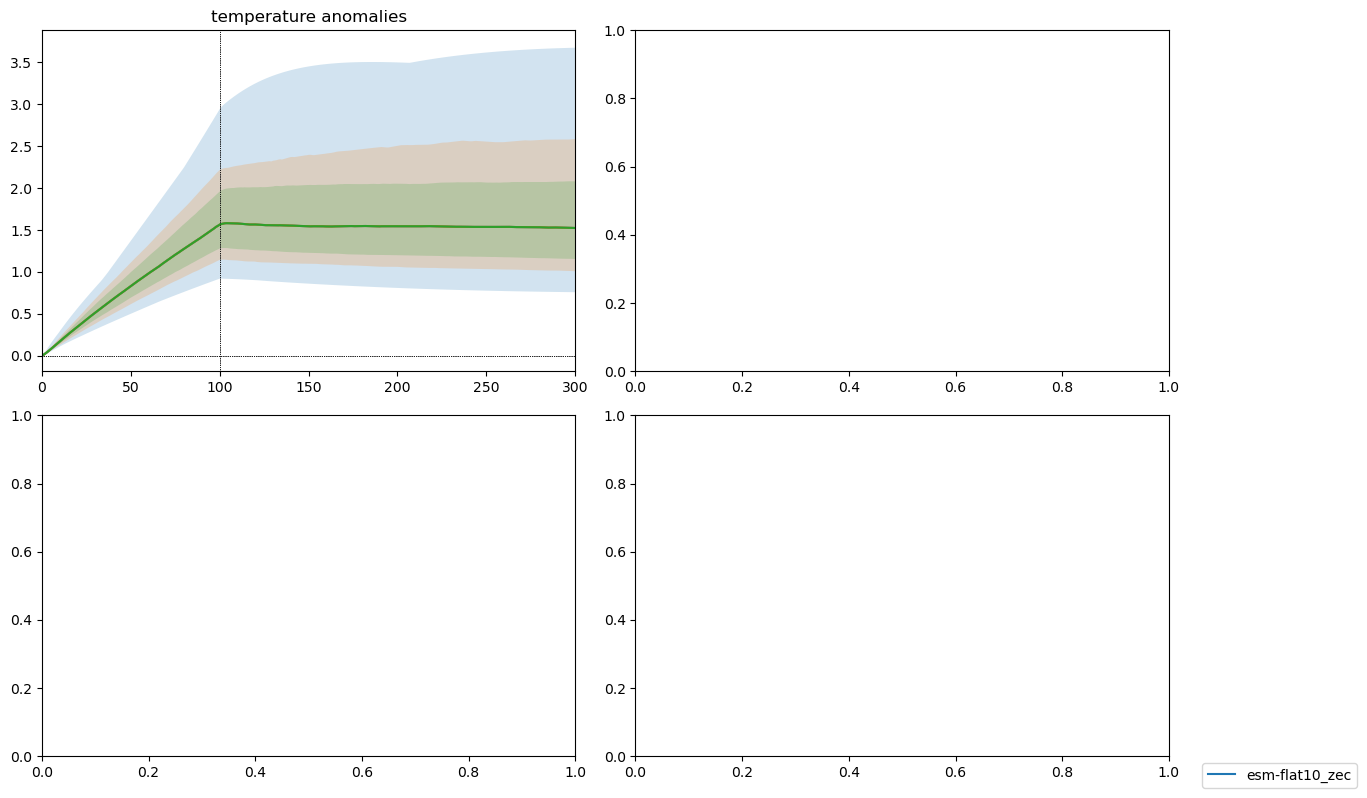

In [40]:
fig, ax = plt.subplots(2, 2, figsize=(12, 8))

for scenario in f.scenarios[1:2]:
    for pp in ((0, 100), (5, 95), (16, 84)):
#         temperature
        ax[0,0].fill_between(
            f.timebounds,
            np.percentile(
                f.temperature.loc[dict(scenario=scenario, layer=0)],
                pp[0],
                axis=1,
            ),
            np.percentile(
                f.temperature.loc[dict(scenario=scenario, layer=0)],
                pp[1],
                axis=1,
            ),
#             color=scenario_colors[scenario],
            alpha=0.2,
            lw=0
        )
        ax[0,0].plot(
            f.timebounds,
            np.median(
                f.temperature.loc[dict(scenario=scenario, layer=0)],
                axis=1,
            ),
#             color=scenario_colors[scenarios[i]],
            label = fancy_titles[scenario] if pp == (0, 100) else '_%s' % scenario,
        )
        ax[0,0].set_xlim(0, 300)
#         ax[0,0].set_ylim(-1, 5)
        ax[0,0].axvline(100, color="k", ls=":", lw=0.5)
        ax[0,0].axhline(0, color="k", ls=":", lw=0.5)
        ax[0,0].set_title("temperature anomalies")

fig.tight_layout()
fig.legend(loc = 'lower left', bbox_to_anchor=(1,0))
plt.show();plt.close()

TypeError: list indices must be integers or slices, not str

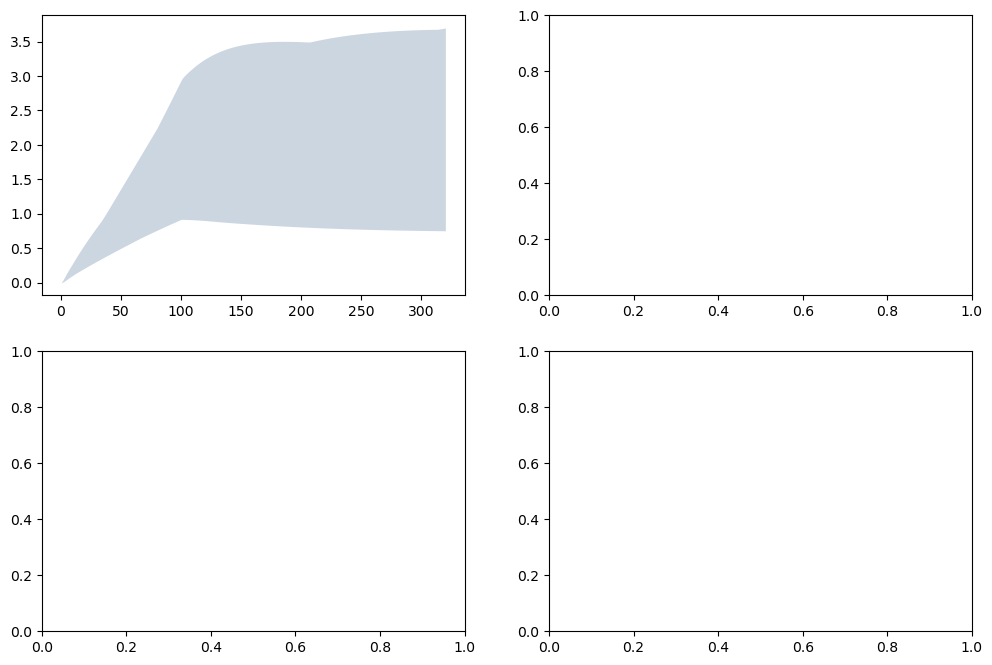

In [41]:
fig, ax = plt.subplots(2, 2, figsize=(12, 8))

for scenario in f.scenarios[1:2]:
    for pp in ((0, 100), (5, 95), (16, 84)):
#         temperature
        ax[0,0].fill_between(
            f.timebounds,
            np.percentile(
                f.temperature.loc[dict(scenario=scenario, layer=0)],
                pp[0],
                axis=1,
            ),
            np.percentile(
                f.temperature.loc[dict(scenario=scenario, layer=0)],
                pp[1],
                axis=1,
            ),
            color=scenario_colors[scenario],
            alpha=0.2,
            lw=0
        )
        ax[0,0].plot(
            f.timebounds,
            np.median(
                f.temperature.loc[dict(scenario=scenario, layer=0)],
                axis=1,
            ),
            color=scenario_colors[scenarios[i]],
            label = fancy_titles[scenario] if pp == (0, 100) else '_%s' % scenario,
        )
        ax[0,0].set_xlim(0, 300)
        ax[0,0].set_ylim(-1, 5)
        ax[0,0].axvline(100, color="k", ls=":", lw=0.5)
        ax[0,0].axhline(0, color="k", ls=":", lw=0.5)
        ax[0,0].set_title("temperature anomalies")

fig.tight_layout()
fig.legend(loc = 'lower left', bbox_to_anchor=(1,0))
plt.show();plt.close()

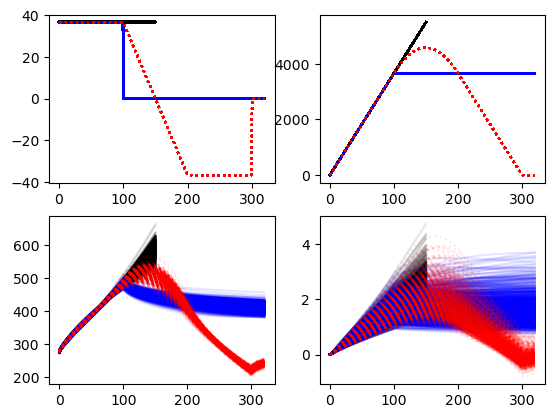

In [43]:
fig, ax = plt.subplots(2, 2)
ax[0,0].plot(f.timepoints[:150], f.emissions.loc[dict(specie="CO2", scenario="esm-flat10", timepoints=np.arange(0.5, 150))], color='k', alpha=0.1);
ax[0,0].plot(f.timepoints, f.emissions.loc[dict(specie="CO2", scenario="esm-flat10_zec")], color='b', alpha=0.1);
ax[0,0].plot(f.timepoints, f.emissions.loc[dict(specie="CO2", scenario="esm-flat10_cdr")], color='r', alpha=0.1, ls=':');
ax[0,1].plot(np.arange(0, 151), f.cumulative_emissions.loc[dict(specie="CO2", scenario="esm-flat10", timebounds=np.arange(0, 151))], color='k', alpha=0.1);
ax[0,1].plot(f.cumulative_emissions.loc[dict(specie="CO2", scenario="esm-flat10_zec")], color='b', alpha=0.1);
ax[0,1].plot(f.cumulative_emissions.loc[dict(specie="CO2", scenario="esm-flat10_cdr")], color='r', alpha=0.1, ls=':');
ax[1,0].plot(np.arange(0, 151), f.concentration.loc[dict(specie="CO2", scenario="esm-flat10", timebounds=np.arange(0, 151))], color='k', alpha=0.1);
ax[1,0].plot(f.concentration.loc[dict(specie="CO2", scenario="esm-flat10_zec")], color='b', alpha=0.1);
ax[1,0].plot(f.concentration.loc[dict(specie="CO2", scenario="esm-flat10_cdr")], color='r', alpha=0.1, ls=':');
ax[1,1].plot(np.arange(0, 151), f.temperature.loc[dict(layer=0, scenario="esm-flat10", timebounds=np.arange(0, 151))], color='k', alpha=0.1);
ax[1,1].plot(f.temperature.loc[dict(layer=0, scenario="esm-flat10_zec")], color='b', alpha=0.1);
ax[1,1].plot(f.temperature.loc[dict(layer=0, scenario="esm-flat10_cdr")], color='r', alpha=0.1, ls=':');

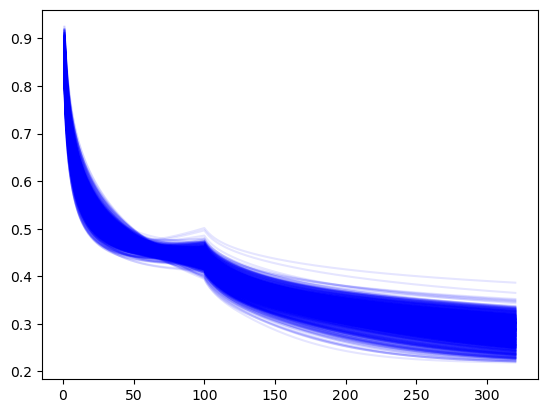

In [44]:
# plt.plot(np.arange(0, 151), f.airborne_fraction.loc[dict(specie="CO2", scenario="esm-flat10", timebounds=np.arange(0, 151))], color='k', alpha=0.1);
plt.plot(f.airborne_fraction.loc[dict(specie="CO2", scenario="esm-flat10_zec")], color='b', alpha=0.1);
# plt.plot(np.arange(0, 291), f.airborne_fraction.loc[dict(specie="CO2", scenario="esm-flat10_cdr", timebounds=np.arange(0, 291))], color='r', alpha=0.1, ls=':');

In [45]:
# TCRE is just warming at year 100
tcre = f.temperature.loc[dict(layer=0, scenario="esm-flat10", timebounds=100)]

# ZEC50 is just warming at year 150 minus year 100
zec50 = (
    f.temperature.loc[dict(layer=0, scenario="esm-flat10_zec", timebounds=150)] - 
    f.temperature.loc[dict(layer=0, scenario="esm-flat10_zec", timebounds=100)]
)

# ZEC100 is just warming at year 200 minus year 100
zec100 = (
    f.temperature.loc[dict(layer=0, scenario="esm-flat10_zec", timebounds=200)] - 
    f.temperature.loc[dict(layer=0, scenario="esm-flat10_zec", timebounds=100)]
)

# ZEC200 is just warming at year 300 minus year 100
zec200 = (
    f.temperature.loc[dict(layer=0, scenario="esm-flat10_zec", timebounds=300)] - 
    f.temperature.loc[dict(layer=0, scenario="esm-flat10_zec", timebounds=100)]
)

# # TNZ can be calculated as a 20 year average around year 150 in esm-flat10-cdr minus a 20 year average around year 125 in esm-flat10
# tnz = (
#     f.temperature.loc[dict(layer=0, scenario="esm-flat10_cdr", timebounds=150)] - 
#     f.temperature.loc[dict(layer=0, scenario="esm-flat10", timebounds=125)]
# )

# TR1000 can be calculated as a 20 year average around year 200 in esm-flat10-cdr minus a 20 year average around year 100 in esm-flat10
tr1000 = (
    f.temperature.loc[dict(layer=0, scenario="esm-flat10_cdr", timebounds=200)] - 
    f.temperature.loc[dict(layer=0, scenario="esm-flat10", timebounds=100)]
)

# TR0 can be calculated as a 20 year average around year 310 in esm-flat10-cdr
tr0 = f.temperature.loc[dict(layer=0, scenario="esm-flat10_cdr", timebounds=310)]

# Time to Peak Warming (tPW) can be calculated as the time difference between the peak value of 20-year smoothed global mean 
# temperatures and the point that net zero is achieved in esm-flat10-cdr (year 150)
tpw = f.temperature.loc[dict(layer=0, scenario="esm-flat10_cdr")].argmax(axis=0) - 150

In [46]:
df = pd.DataFrame(
    {
        "tcre": tcre,
        "zec50": zec50,
        "zec100": zec100,
        "zec200": zec200,
        "tr1000": tr1000,
        "tr0": tr0,
        "tpw": tpw,
    },
    index = f.configs
)

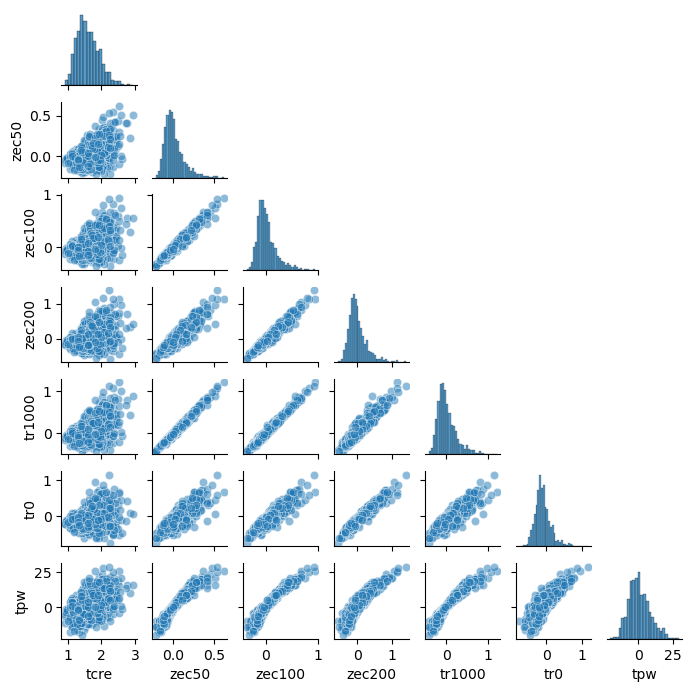

In [47]:
import seaborn as sns

sns.pairplot(
    df,
    corner=True,
    plot_kws={"alpha": 0.5},
    height=1,
)

In [48]:
os.makedirs('../output/', exist_ok=True)
df.to_csv('../output/flat10_key-metrics_fair2.1.3csv')

In [49]:
os.makedirs('../output/', exist_ok=True)
df.to_csv('../output/flat10_key-metrics_fair2.1.3.csv')
ds = xr.Dataset(
    data_vars=dict(
        temperature=(["time", "scenario", "config"], f.temperature.loc[dict(layer=0)].data),
        co2_concentration=(["time", "scenario", "config"], f.concentration.loc[dict(specie="CO2")].data),
        airborne_fraction=(["time", "scenario", "config"], f.airborne_fraction.loc[dict(specie="CO2")].data),
        ecs=(["config"], f.ebms.ecs.data),
        tcr=(["config"], f.ebms.tcr.data),
        tcre=(["config"], tcre.data),
        zec50=(["config"], zec50.data),
        zec100=(["config"], zec100.data),
        zec200=(["config"], zec200.data),
        tr1000=(["config"], tr1000.data),
        tr0=(["config"], tr0.data),
        tpw=(["config"], tpw.data),
    ),
    coords=dict(
        time=np.arange(321),
        config=list(df_configs.index),
        scenario=scenarios
    ),
)

In [50]:
ds.to_netcdf('../output/flat10_all-output_fair2.1.3.nc')

In [ ]:
fig = plt.figure()
for i, scenario in enumerate(scenarios):
    for pp in ((0, 100), (5, 95), (16, 84)):
        plt.fill_between(
            f.timebounds,
            np.percentile(
                f.temperature.loc[dict(scenario=scenario, layer=0)],
                pp[0],
                axis=1,
            ),
            np.percentile(
                f.temperature.loc[dict(scenario=scenario, layer=0)],
                pp[1],
                axis=1,
            ),
#             color=ar6_colors[scenario],
            alpha=0.2,
            lw=0
        )

        plt.plot(
            f.timebounds,
            np.median(
                f.temperature.loc[dict(scenario=scenario, layer=0)],
                axis=1,
            ),
#             color=ar6_colors[scenarios[i]],
        )
    #     ax[i // 4, i % 4].plot(np.arange(1850.5, 2021), gmst, color="k")
        plt.xlim(0, 300)
        plt.ylim(-1, 5)
        plt.axvline(100, color="k", ls=":", lw=0.5)
        plt.axhline(0, color="k", ls=":", lw=0.5)
        plt.title(fancy_titles[scenario])

plt.suptitle("temperature anomalies")
fig.tight_layout()
plt.show();plt.close()

### CO2 concentrations

In [ ]:
# fig, ax = pl.subplots(2, 4, figsize=(12, 6))

# for i, scenario in enumerate(scenarios):
#     for pp in ((0, 100), (5, 95), (16, 84)):
#         ax[i // 4, i % 4].fill_between(
#             f.timebounds,
#             np.percentile(
#                 f.concentration.loc[dict(scenario=scenario, specie='CO2')],
#                 pp[0],
#                 axis=1,
#             ),
#             np.percentile(
#                 f.concentration.loc[dict(scenario=scenario, specie='CO2')],
#                 pp[1],
#                 axis=1,
#             ),
#             color=ar6_colors[scenarios[i]],
#             alpha=0.2,
#             lw=0
#         )

#     ax[i // 4, i % 4].plot(
#         f.timebounds,
#         np.median(
#             f.concentration.loc[dict(scenario=scenario, specie='CO2')],
#             axis=1,
#         ),
#         color=ar6_colors[scenarios[i]],
#     )
#     ax[i // 4, i % 4].set_xlim(1850, 2300)
#     ax[i // 4, i % 4].set_ylim(0, 2500)
#     ax[i // 4, i % 4].axhline(0, color="k", ls=":", lw=0.5)
#     ax[i // 4, i % 4].set_title(fancy_titles[scenarios[i]])

# pl.suptitle("SSP CO$_2$ concentration")
# fig.tight_layout()

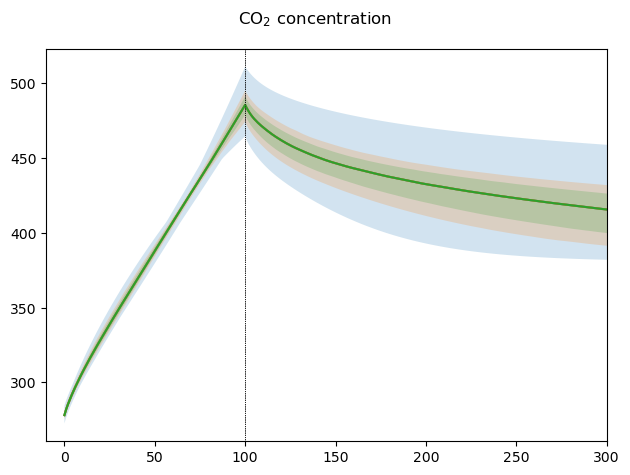

In [51]:
fig = plt.figure()

# for i, scenario in enumerate(scenarios):
for i, scenario in enumerate(f.scenarios):
    if i == 0:
        pass
    elif i == 2:
        pass
    else:
        for pp in ((0, 100), (5, 95), (16, 84)):
            plt.fill_between(
                f.timebounds,
                np.percentile(
                    f.concentration.loc[dict(scenario=scenario, specie='CO2')],
                    pp[0],
                    axis=1,
                ),
                np.percentile(
                    f.concentration.loc[dict(scenario=scenario, specie='CO2')],
                    pp[1],
                    axis=1,
                ),
    #             color=ar6_colors[scenarios[i]],
                alpha=0.2,
                lw=0
            )

            plt.plot(
                f.timebounds,
                np.median(
                    f.concentration.loc[dict(scenario=scenario, specie='CO2')],
                    axis=1,
                ),
    #             color=ar6_colors[scenarios[i]],
            )
            plt.xlim(-10, 300)

            plt.axvline(100, color="k", ls=":", lw=0.5)
    #         pl.axhline(0, color="k", ls=":", lw=0.5)
    #         plt.title(fancy_titles[scenarios[i]])

plt.suptitle("CO$_2$ concentration")
fig.tight_layout()
plt.show();plt.close()

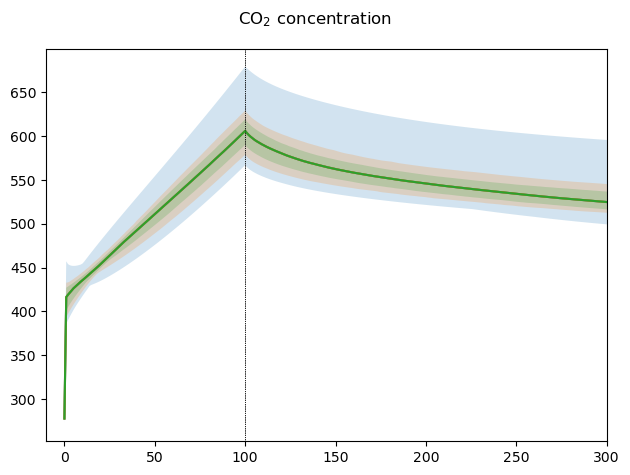

### Total effective radiative forcing

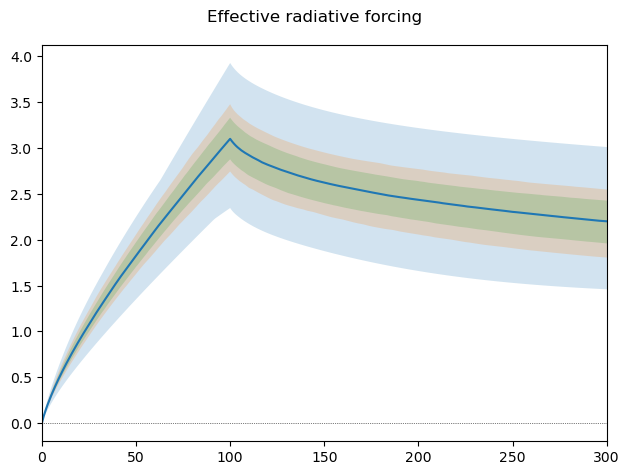

In [54]:
fig = plt.figure()

for i, scenario in enumerate(scenarios):
    if i == 0:
        pass
    elif i == 2:
        pass
    else:
        for pp in ((0, 100), (5, 95), (16, 84)):
            plt.fill_between(
                f.timebounds,
                np.percentile(
                    f.forcing_sum.loc[dict(scenario=scenario)],
                    pp[0],
                    axis=1,
                ),
                np.percentile(
                    f.forcing_sum.loc[dict(scenario=scenario)],
                    pp[1],
                    axis=1,
                ),
#                 color=ar6_colors[scenarios[i]],
                alpha=0.2,
                lw=0
            )

        plt.plot(
                f.timebounds,
                np.median(
                f.forcing_sum.loc[dict(scenario=scenario)],
                axis=1,
            ),
#             color=ar6_colors[scenarios[i]],
        )
        plt.xlim(0, 300)
    #     pl.ylim(0, 15)
        plt.axhline(0, color="k", ls=":", lw=0.5)
#         pl.title(fancy_titles[scenarios[i]])

plt.suptitle("Effective radiative forcing")
fig.tight_layout()

### CO2 airborne fraction

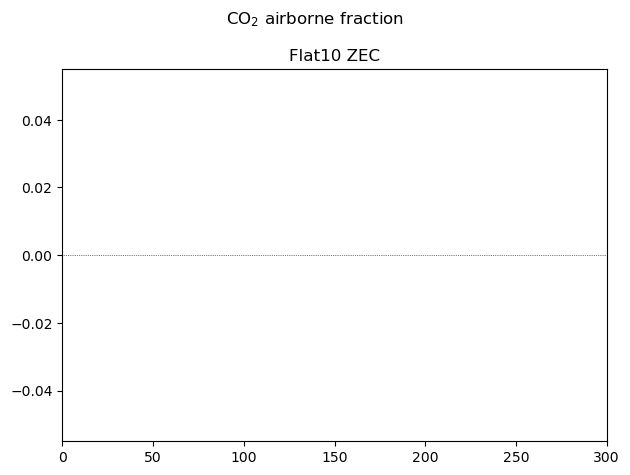

In [45]:
fig = plt.figure()

for i, scenario in enumerate(scenarios):
    for pp in ((0, 100), (5, 95), (16, 84)):
        pl.fill_between(
            f.timebounds,
            np.percentile(
                f.airborne_fraction.loc[dict(scenario=scenario, specie='CO2')],
                pp[0],
                axis=1,
            ),
            np.percentile(
                f.airborne_fraction.loc[dict(scenario=scenario, specie='CO2')],
                pp[1],
                axis=1,
            ),
            color=ar6_colors[scenarios[i]],
            alpha=0.2,
            lw=0
        )

    plt.plot(
        f.timebounds,
        np.median(
            f.airborne_fraction.loc[dict(scenario=scenario, specie='CO2')],
            axis=1,
        ),
        color=ar6_colors[scenarios[i]],
    )
    plt.xlim(0, 300)
#     pl.ylim(0, 1)
    plt.axhline(0, color="k", ls=":", lw=0.5)
    pl.title(fancy_titles[scenarios[i]])

plt.suptitle("CO$_2$ airborne fraction")
fig.tight_layout()

### Earth's energy uptake

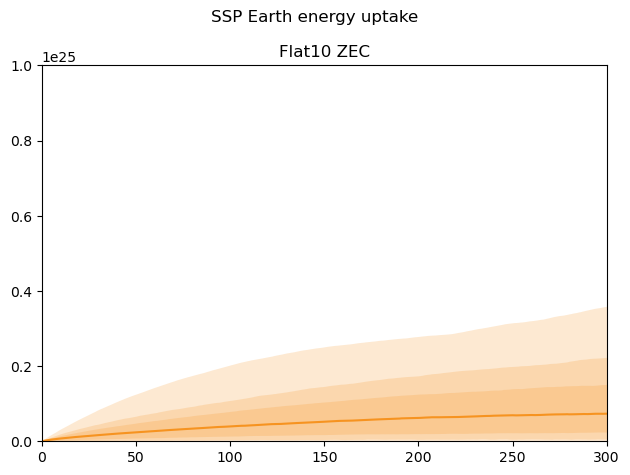

In [44]:
fig = pl.figure()

for i, scenario in enumerate(scenarios):
    for pp in ((0, 100), (5, 95), (16, 84)):
        pl.fill_between(
            f.timebounds,
            np.percentile(
                f.ocean_heat_content_change.loc[dict(scenario=scenario)],
                pp[0],
                axis=1,
            ),
            np.percentile(
                f.ocean_heat_content_change.loc[dict(scenario=scenario)],
                pp[1],
                axis=1,
            ),
            color=ar6_colors[scenarios[i]],
            alpha=0.2,
            lw=0
        )

    pl.plot(
        f.timebounds,
        np.median(
            f.ocean_heat_content_change.loc[dict(scenario=scenario)],
            axis=1,
        ),
        color=ar6_colors[scenarios[i]],
    )
    pl.xlim(0, 300)
    pl.ylim(0, 1e25)
    pl.axhline(0, color="k", ls=":", lw=0.5)
    pl.title(fancy_titles[scenarios[i]])

pl.suptitle("SSP Earth energy uptake")
fig.tight_layout()